### Business goal
In order to facilitate public health, based on food nutritional data, propose an idea and create the corresponding algorithm for further application.

   - data source: https://world.openfoodfacts.org/
   - data description: https://world.openfoodfacts.org/data/data-fields.txt
   - data reference : https://www.santepubliquefrance.fr/determinants-de-sante/nutrition-et-activite-physique/notre-action/#tabs
   - detailed project decription: https://openclassrooms.com/fr/paths/164/projects/628/assignment

---
### My process: 
1. ideation
2. data pre-processing (data cleansing and transformation)
3. data modeling and algorithm deployment in business 

NB: this notebook deals with the modeling and deployment of model, supported by data visualisation. 

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
%matplotlib inline

from scipy import stats
from scipy.special import comb

import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
#from statsmodels.compat.numpy import NP_LT_123



- Exploratory Data Analysis 
     - univariate analysis
     - bivariate and multivariate analysis: 
           - Correlation
           - ANOVA
           - prediction model - linear regression 
           - deal with null data : imputation with sklearn imputer 
           - dimension reduction by PCA 
     
- Scoring 

## Exploratory Data Analysis
### Univariate analysis 

In [114]:
df2= pd.read_csv('P3_openfoodfacts_cleaned_df.csv').drop(columns=['Unnamed: 0']).set_index('code')
df2.head(1)

,product_name,category,countries_fr,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,nutrigrade
code,,,,,,,,,,
36252,Lion Peanut x2,NaN,"France,États-Unis",1883.0,12.5,57.5,2.5,0.0,22.0,e


<AxesSubplot:>

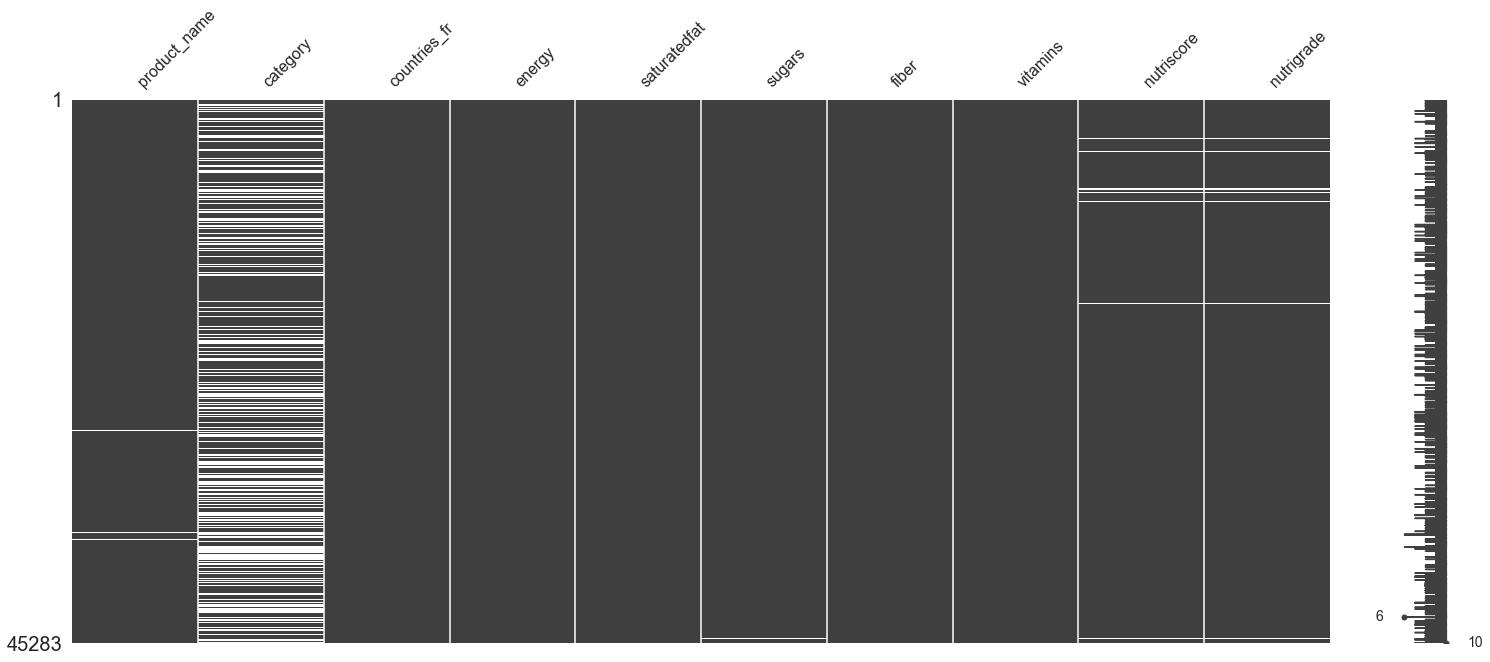

In [74]:
# check the completeness of dataset
import missingno as msno
msno.matrix(df2)

In [75]:
df2.corr()

,energy,saturatedfat,sugars,fiber,vitamins,nutriscore
energy,1.000000,0.555810,0.332346,0.236066,0.004439,0.610003
saturatedfat,0.555810,1.000000,0.114332,0.007408,-0.008079,0.608575
sugars,0.332346,0.114332,1.000000,0.035386,0.010744,0.482103
fiber,0.236066,0.007408,0.035386,1.000000,0.007991,-0.135474
vitamins,0.004439,-0.008079,0.010744,0.007991,1.000000,-0.001382
nutriscore,0.610003,0.608575,0.482103,-0.135474,-0.001382,1.000000


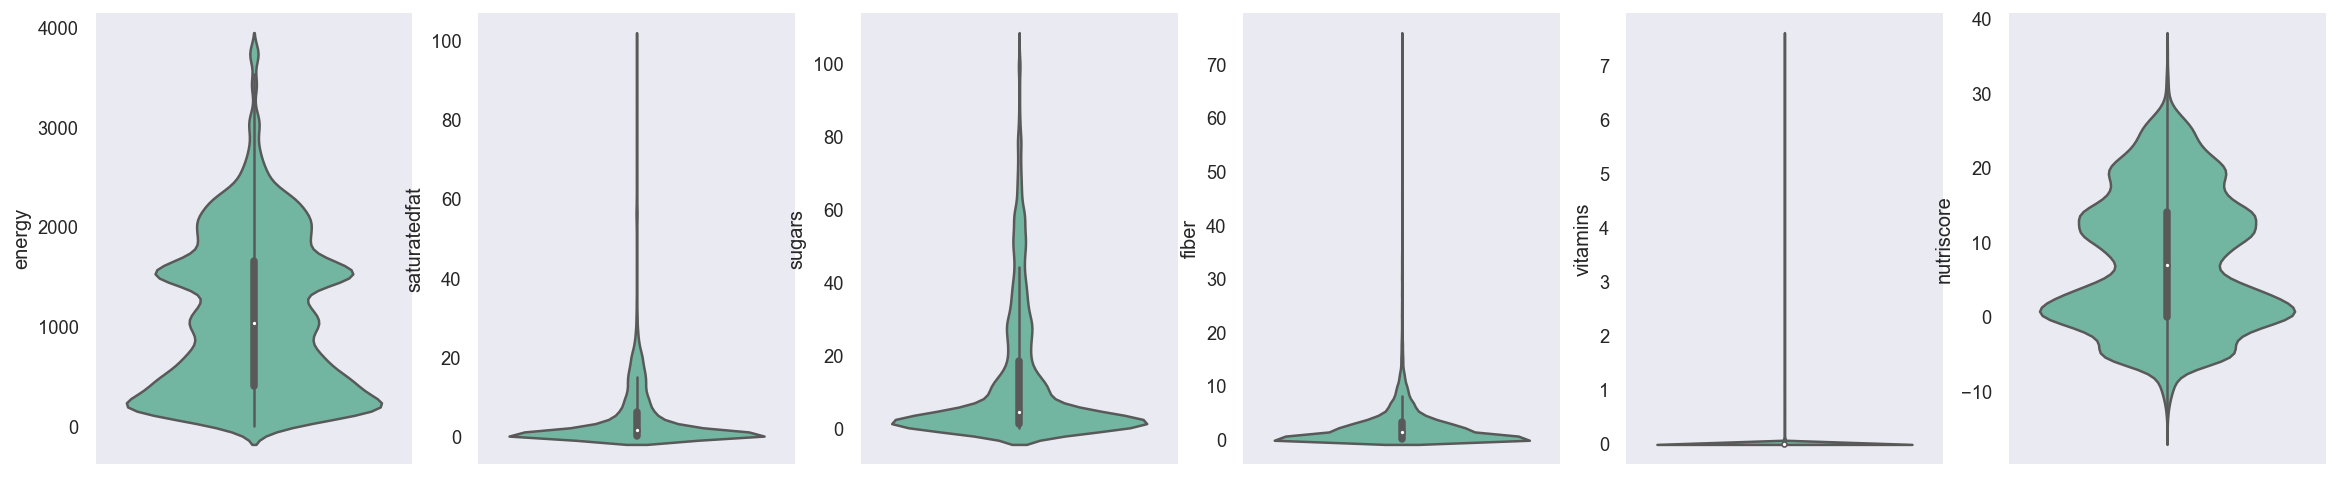

In [77]:
# value distribution of features

plt.figure(figsize= (24,5), dpi=120)
sns.set(style="dark")

plt.subplot(1,6,1)
ax=sns.violinplot(y="energy",
                 data=df2, palette="Set2")

plt.subplot(1,6,2)
ax=sns.violinplot(y="saturatedfat", 
                 data=df2, palette="Set2")

plt.subplot(1,6,3)
ax=sns.violinplot(y="sugars",
                 data=df2, palette="Set2")

plt.subplot(1,6,4)
ax=sns.violinplot(y="fiber", 
                 data=df2, palette="Set2")

plt.subplot(1,6,5)
ax=sns.violinplot(y="vitamins",  
                 data=df2, palette="Set2")

plt.subplot(1,6,6)
ax=sns.violinplot(y="nutriscore",  
                 data=df2, palette="Set2")
plt.show()

-----
#### Groupby category, nutrigrade, nutriscore
#### aggfunc count(), mean()

In [78]:
df_group= df2.groupby('category').mean().sort_values('nutriscore', ascending=False)
#print(df_group.info())
df_group.head(2)

,energy,saturatedfat,sugars,fiber,vitamins,nutriscore
category,,,,,,
"Aliments et boissons à base de végétaux,Aliments d'origine végétale,Céréales et pommes de terre,Céréales et dérivés,Nouilles,Nouilles instantanées,Soupes-de-nouilles",1920.0,19.0,62.0,0.0,0.0,35.0
"Boissons,Boissons chaudes,Cafés,Café en dosettes,Boissons non sucrées,Café en dosettes compatible Senseo,Boissons sucrées,Arabica,Cappuccino,Cappuccino-en-dosettes",1925.0,16.5,45.0,0.0,0.0,35.0


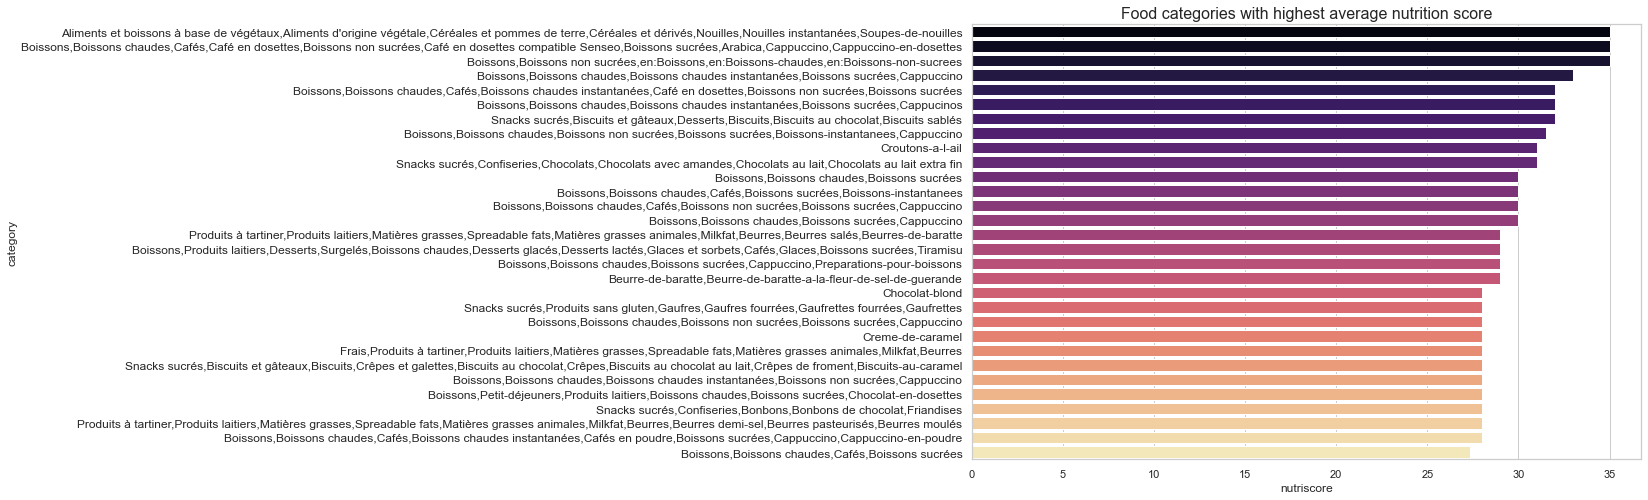

In [79]:
plt.figure(figsize=(12,8))
sns.set(style='whitegrid')
ax = sns.barplot(y=df_group.index[:30], x=df_group['nutriscore'][:30], palette= 'magma')
plt.title('Food categories with highest average nutrition score', fontsize=16)
plt.yticks(fontsize=12)
plt.show()

(1087, 9)


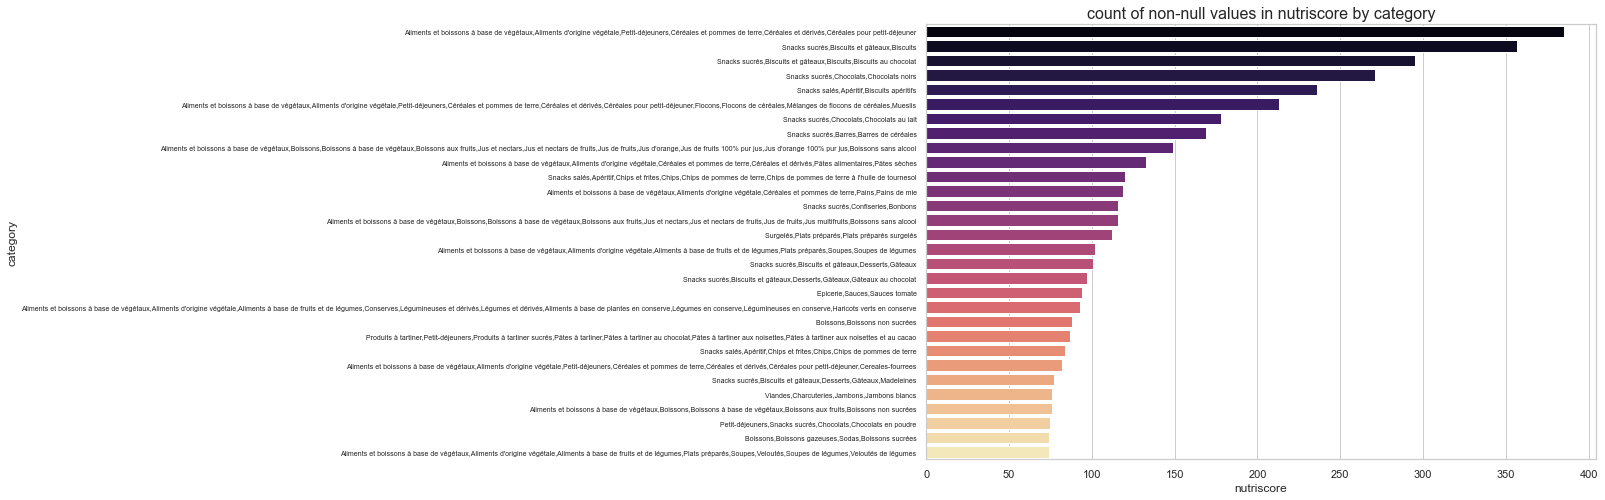

In [80]:
df_categ_count= df2.groupby('category').count().sort_values('nutriscore', ascending=False)
df_categ_5= df_categ_count.loc[df_categ_count.nutriscore >=5]   # with nutriscore have >=5 non-null values 
print(df_categ_5.shape)

plt.figure(figsize=(12,8))
sns.set(style='whitegrid')
ax = sns.barplot(y=df_categ_5.index[:30], x=df_categ_5['nutriscore'][:30], palette= 'magma')
plt.title('count of non-null values in nutriscore by category', fontsize=16)
plt.yticks(fontsize=7)
plt.show()

In [81]:
# keep only the categories where their nutriscore have >= 5 nb of non-null values 
DF = df2[df2['category'].isin(df_categ_5.index.values)]
print(DF.shape)
DF.describe()

#the size of DF is largely smaller than that of df2

(18985, 10)


,energy,saturatedfat,sugars,fiber,vitamins,nutriscore
count,18985.000000,18985.000000,18945.00000,18985.000000,18985.000000,18825.000000
mean,1133.736775,4.638353,13.76352,2.740316,0.002578,7.126799
std,811.949490,7.901386,17.81624,3.577958,0.056725,9.062476
min,0.000000,0.000000,0.00000,0.000000,0.000000,-14.000000
25%,340.000000,0.200000,1.60000,0.500000,0.000000,0.000000
50%,1066.000000,1.200000,5.20000,1.900000,0.000000,6.000000
75%,1779.000000,5.900000,21.00000,3.600000,0.000000,14.000000
max,3770.000000,95.000000,104.00000,70.000000,4.406467,34.000000


Text(0.5, 1.0, 'correlation heatmap_DF_group by category')

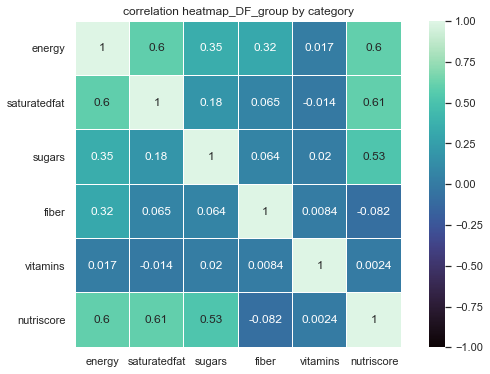

In [82]:
plt.figure(figsize = (10,6))
sns.heatmap(DF.corr(),
            linewidths=.01,  
            annot=True, 
            square=True,
            cmap='mako',
            vmax=1,
            vmin=-1)

plt.title('correlation heatmap_DF_group by category')

(5, 9)


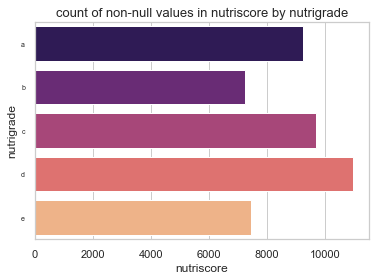

In [83]:
# groupby nutrigrade
df_grade_count= df2.groupby('nutrigrade').count()#.sort_values('nutriscore', ascending=False)
df_grade_5= df_grade_count.loc[df_grade_count.nutriscore >=5]   # with nutriscore have >=5 non-null values 
print(df_grade_5.shape)

plt.figure()
sns.set(style='whitegrid')
ax = sns.barplot(y=df_grade_5.index, x=df_grade_5['nutriscore'], palette= 'magma')
plt.title('count of non-null values in nutriscore by nutrigrade', fontsize=13)
plt.yticks(fontsize=7)
plt.show()

In [84]:
df_grade_5.head(2)

,product_name,category,countries_fr,energy,saturatedfat,sugars,fiber,vitamins,nutriscore
nutrigrade,,,,,,,,,
a,9216,6855,9262,9262,9262,9262,9262,9262,9262
b,7208,4476,7245,7245,7245,7245,7245,7245,7245


(44674, 10)


Text(0.5, 1.0, 'correlation heatmap_DF grade_group by nutrigrade')

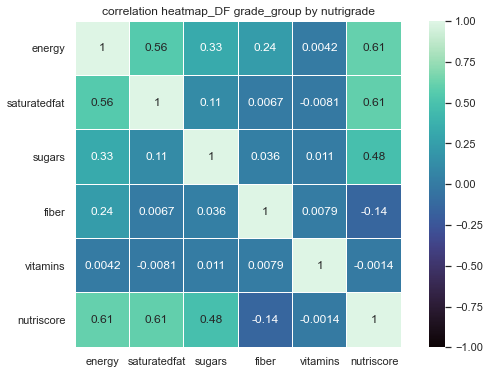

In [85]:
DF_grade = df2[df2['nutrigrade'].isin(df_grade_5.index.values)]
print(DF_grade.shape)
DF_grade.describe()

plt.figure(figsize = (10,6))
sns.heatmap(DF_grade.corr(),
            linewidths=.01,  
            annot=True, 
            square=True,
            cmap='mako',
            vmax=1,
            vmin=-1)
plt.title('correlation heatmap_DF grade_group by nutrigrade')

In [86]:
df_group2= df2.groupby('nutriscore').mean() 
df_group2.head(1)

,energy,saturatedfat,sugars,fiber,vitamins
nutriscore,,,,,
-15.0,317.0,0.7,2.4,21.4,0.0


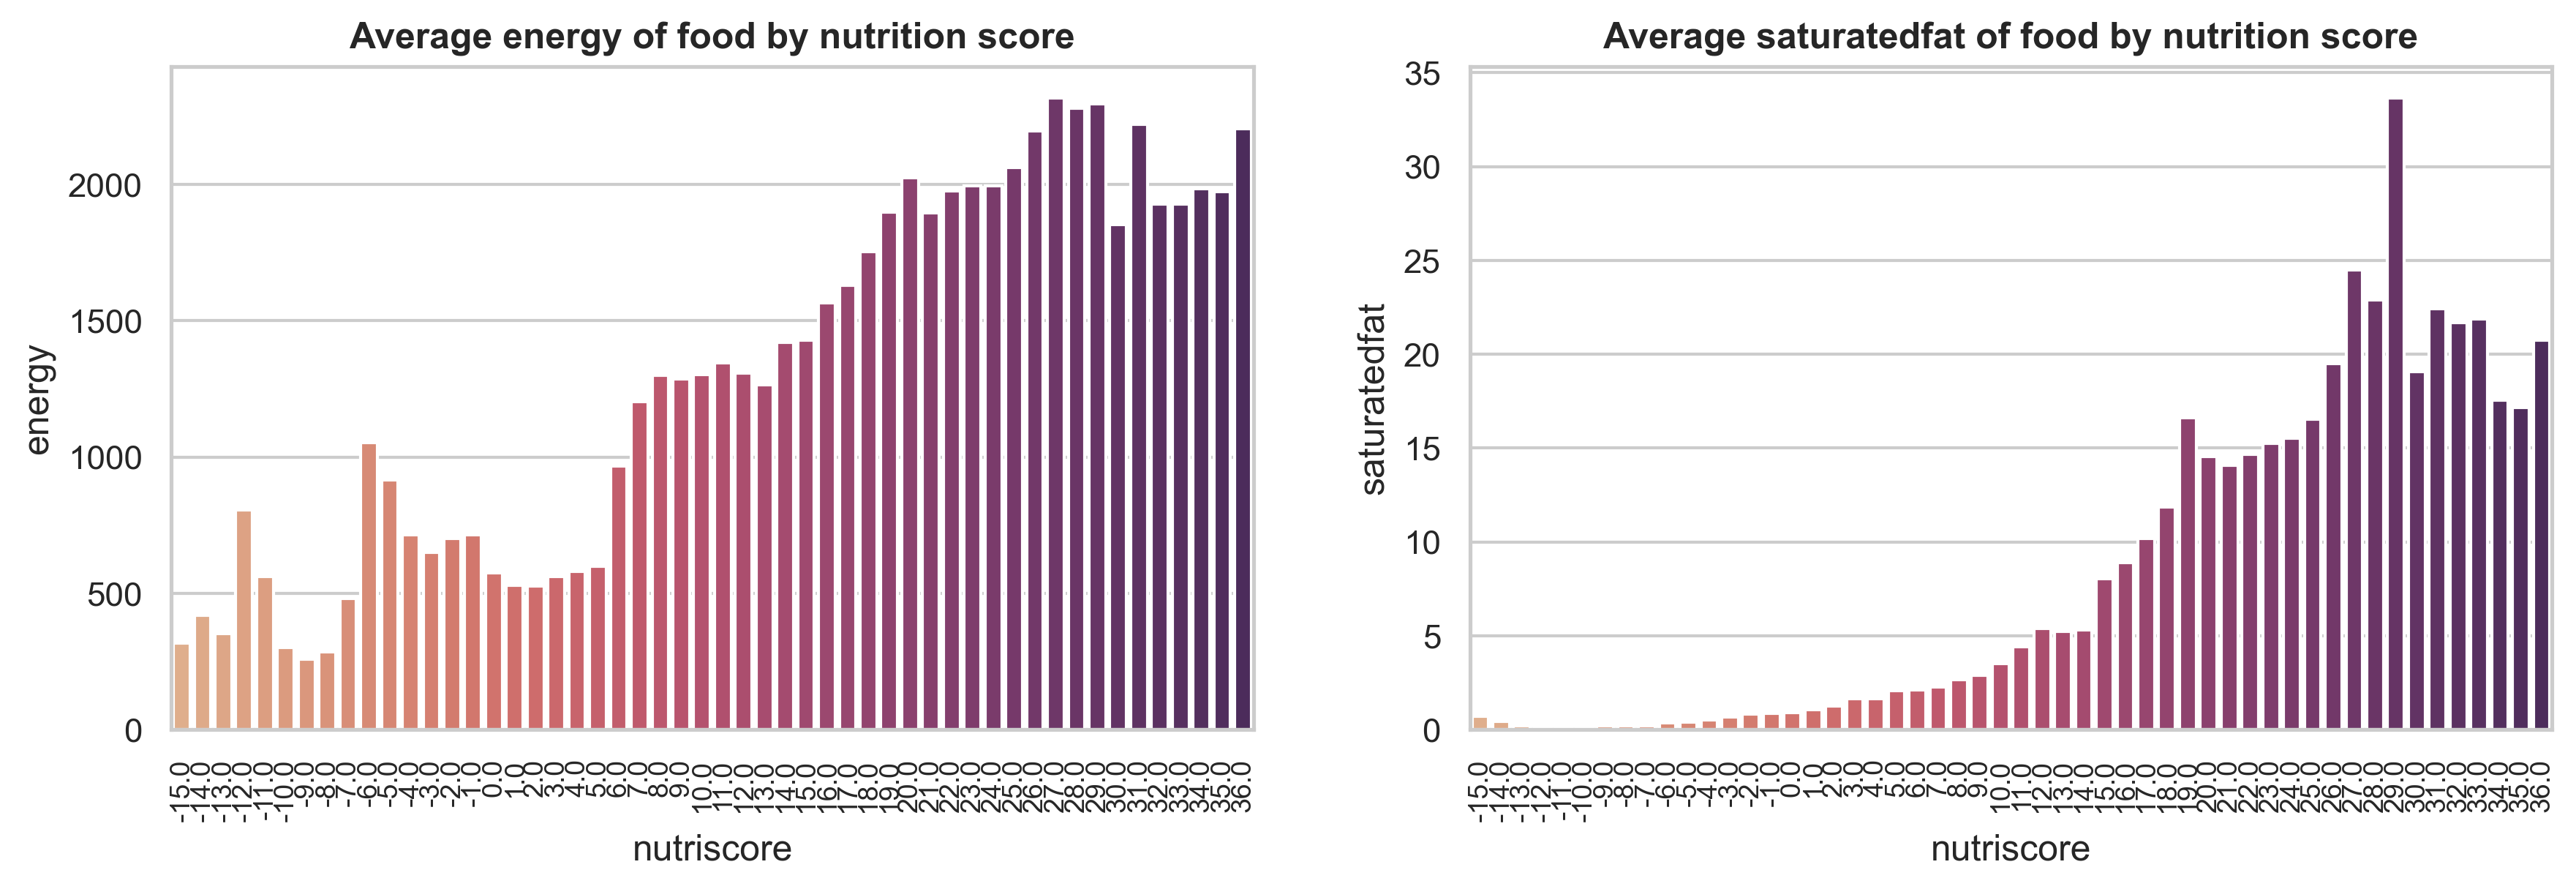

In [87]:
plt.figure(figsize=(14,4),dpi=300)
sns.set(style='whitegrid')
plt.subplot(1,2,1)
ax1 = sns.barplot(x=df_group2.index, y=df_group2['energy'], palette= 'flare')
plt.title('Average energy of food by nutrition score', fontsize=12, fontweight="bold")
plt.xticks(fontsize=9, rotation=90)

plt.subplot(1,2,2)
ax2 = sns.barplot(x=df_group2.index, y=df_group2['saturatedfat'], palette= 'flare')
plt.title('Average saturatedfat of food by nutrition score', fontsize=12, fontweight="bold")
plt.xticks(fontsize=9, rotation=90)

plt.show()

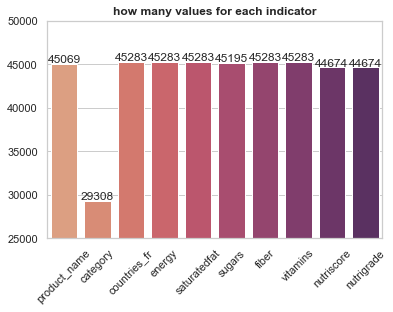

In [88]:
count= df2.count()
#plt.figure(figsize=(8,5))
sns.set(style='whitegrid')
ax = sns.barplot(x= df2.columns, y= round(df2.count(),0), palette= 'flare')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2, p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 4), 
                   textcoords = 'offset points')
plt.title('how many values for each indicator', fontsize=12, fontweight="bold")
plt.xticks(fontsize=11, rotation=45)
plt.ylim(25000,50000)
plt.show()

In [89]:
round(df2.count(),0)

product_name    45069
category        29308
countries_fr    45283
energy          45283
saturatedfat    45283
sugars          45195
fiber           45283
vitamins        45283
nutriscore      44674
nutrigrade      44674
dtype: int64

-------

### bivariate and multivariate analysis: 
           - Correlation
           - ANOVA
           - prediction model - linear regression 
           - deal with null data : imputation with sklearn imputer 
           - dimension reduction by PCA 

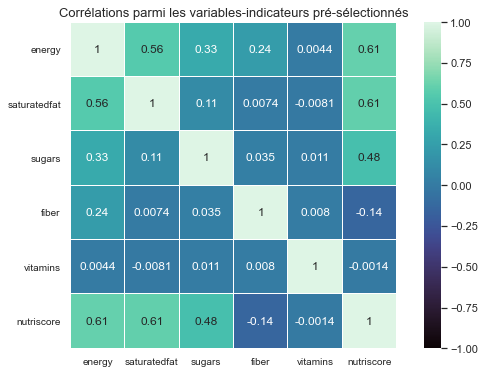

In [90]:
plt.figure(figsize = (10,6))
sns.heatmap(df2.corr(),
             linewidths=.05,  
            annot=True, 
            square=True,
            cmap='mako',
            vmax=1,
            vmin=-1)
plt.title('Corrélations parmi les variables-indicateurs pré-sélectionnés', size=13);
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

nutriscore se corrèle fortement et positivement avec energy, saturatedfat et sugars, il existe de très faible corrélation entre nutriscore et fiber vitamins. 

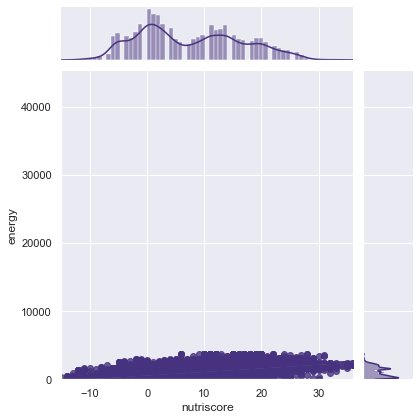

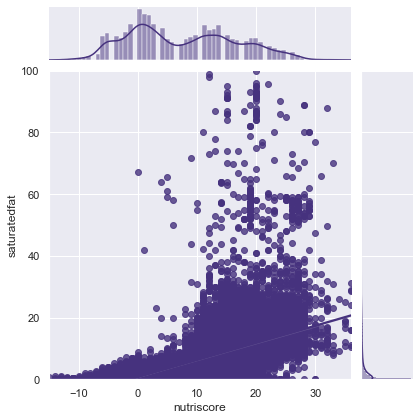

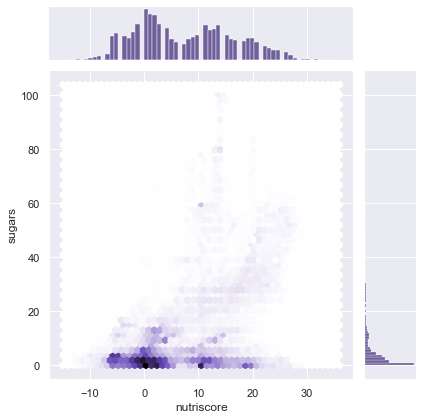

In [229]:
#sns.set_theme(style="whitegrid")
#plt.figure(figsize=(20,6), dpi=200)
sns.set(style="darkgrid", palette='viridis', )
ax= sns.jointplot(x= 'nutriscore', y= 'energy', data =df2, kind='reg',  ylim=(0, len(df2)))
ax= sns.jointplot(x='nutriscore',y='saturatedfat', data =df2, kind='reg',  ylim=(0, df2.saturatedfat.max())) 
ax= sns.jointplot(x= 'nutriscore', y= 'sugars', data =df2,  kind="hex")
plt.show()

<Figure size 2880x600 with 0 Axes>

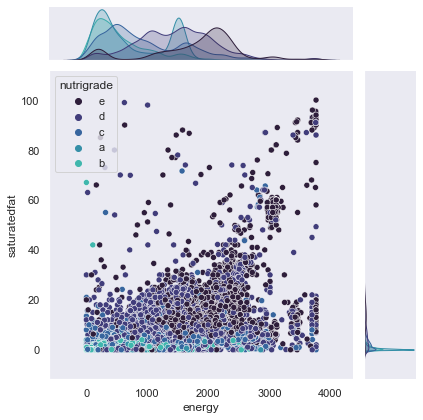

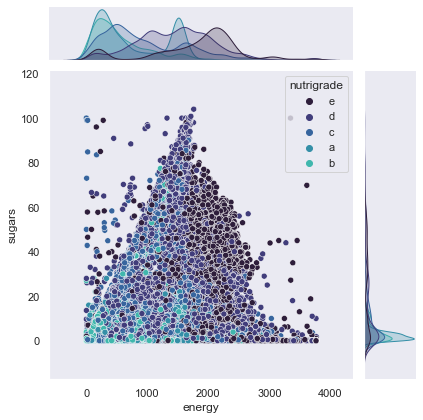

In [205]:
plt.figure(figsize= (24,5), dpi=120)
sns.set(style="dark",palette='mako')
ax = sns.jointplot(y= 'saturatedfat', x= 'energy', data =df2, hue="nutrigrade") 
ax= sns.jointplot(y= 'sugars', x= 'energy', data =df2, hue="nutrigrade") 
plt.show()

- 1,2,3: nutriscore vs energy has a strong possibility of linear reg, with other indicators non. 
- 4,5: energy can't have a linear reg with neither sugars nor saturatedfat
- 4,5: Distribution of these 3 indicators vary as per the nutrigrade. 

### ANOVA 
 Qualitative categorical feature: nutrigrade. So we use nutrigrade as explicative variable in Anova. 

In [93]:
df2.head(1)

,product_name,category,countries_fr,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,nutrigrade
code,,,,,,,,,,
36252,Lion Peanut x2,NaN,"France,États-Unis",1883.0,12.5,57.5,2.5,0.0,22.0,e


In [94]:
df_category= df2.dropna(subset=['category']).sort_values('nutriscore')[:200]
df_category.head(1)

,product_name,category,countries_fr,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,nutrigrade
code,,,,,,,,,,
3380390204408,Pois chiches,"Aliments et boissons à base de végétaux,Alimen...",France,317.0,0.7,2.4,21.4,0.0,-15.0,a


In [226]:
#Anova_category= ols('nutriscore~category', data=df_category).fit()
#Anova_category.summary()

F-stat little, Prob(F-stat) is close to F-stat, many P-values <5%: 
=> for products of many categories, difference in their nutriscore can be accessed by the category they are in. And the variation of category can explain > 65 % of variation in nutriscore. 

In [96]:
#ANOVA via statsmodel 
Anova_grade1= ols('saturatedfat~nutrigrade', data=df2).fit()
Anova_grade1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           saturatedfat   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     5978.
Date:                Sat, 27 Aug 2022   Prob (F-statistic):               0.00
Time:                        12:24:25   Log-Likelihood:            -1.4799e+05
No. Observations:               44674   AIC:                         2.960e+05
Df Residuals:                   44669   BIC:                         2.960e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5922      0.069      8.577      0.000       0.457       0.728
nutrigrade[T.b]     0.4917      0.104      4.719      0.000       0.287       0.696
nutrigrade[T.c]     1.7668      0.096     18.309      0.000       1.578       1.956
nutrigrade[T.d]     6.4345      0.094     68.658      0.000       6.251       6.618
nutrigrade[T.e]    13.7546      0.103    133.074      0.000      13.552      13.957
==============================================================================
Omnibus:                    41989.848   Durbin-Watson:                   1.447
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2910988.470
Skew:                           4.401   Prob(JB):                         0.00
Kurtosis:                      41.554   Cond. No.                         5.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### ANOVA
Analyse de la variance des moyennes parmi les groupes(sous-population). M1, M2, M3...

H0 : égalité en terme de moyenne de différents groupes.
Ha: au moins une moyenne est différente des autres moyennes.

=> P-values <0.5%, rejet de H0, donc il exsite au moins une moyenne qui est très différente des autres moyennes. 

=> difference in saturatedfat can be accessed by differences in nutrisgrade. and the variation of nutriscore can explain 34.9% of variation in saturatedfat.

In [97]:
# ANOVA via scipy 
analyse1=sm.stats.anova_lm(Anova_grade1, typ=1)
analyse1

# type 1 suppose that there's interaction effects among independant variables , and the first-order variable is more important than the following variables 

,df,sum_sq,mean_sq,F,PR(>F)
nutrigrade,4.0,1.055667e+06,263916.735021,5977.82393,0.0
Residual,44669.0,1.972105e+06,44.149299,NaN,NaN


In [98]:
# Anova via scipy
SCE_nutrigrade=analyse1.iloc[0,1]                                              #sum_sq   #SCE (Somme des Carrés Expliquées) 
SCR=analyse1.iloc[1,1]                                                                 #SCR (Somme des Carrés des Résidus) 

R2_nutrigrade=SCE_nutrigrade/sum(analyse1['sum_sq'])                    # SCT  = SCE (variance expliquée par toutes les variables du modèle ou seulement par la variable en question) + SCR 
print("nutrigrade peut expliquer la variance de saturatedfat à", round(R2_nutrigrade*100, 2), '%')

R2_Residu=SCR/sum(analyse1['sum_sq'])
print('la variance de saturatedfat expliquée par les autres facteurs aléatoire:', round(R2_Residu*100, 2), '%')

nutrigrade peut expliquer la variance de saturatedfat à 34.87 %
la variance de saturatedfat expliquée par les autres facteurs aléatoire: 65.13 %


In [99]:
#ici nutrigrade est variable catégorielle, onle prend pour explicative 
Anova_grade2= ols('energy~nutrigrade', data=df2).fit()
Anova_grade2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 energy   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     5270.
Date:                Sat, 27 Aug 2022   Prob (F-statistic):               0.00
Time:                        12:24:25   Log-Likelihood:            -3.5191e+05
No. Observations:               44674   AIC:                         7.038e+05
Df Residuals:                   44669   BIC:                         7.039e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         752.4025      6.629    113.494      0.000     739.409     765.396
nutrigrade[T.b]  -194.5144     10.007    -19.438      0.000    -214.128    -174.901
nutrigrade[T.c]   194.6979      9.266     21.012      0.000     176.536     212.859
nutrigrade[T.d]   710.5917      8.999     78.963      0.000     692.954     728.230
nutrigrade[T.e]  1048.4704      9.925    105.642      0.000    1029.018    1067.923
==============================================================================
Omnibus:                     1228.814   Durbin-Watson:                   1.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1579.324
Skew:                           0.333   Prob(JB):                         0.00
Kurtosis:                       3.635   Cond. No.                         5.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
Anova_grade3= ols('fiber~nutrigrade', data=df2).fit()
Anova_grade3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  fiber   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     555.4
Date:                Sat, 27 Aug 2022   Prob (F-statistic):               0.00
Time:                        12:24:25   Log-Likelihood:            -1.2550e+05
No. Observations:               44674   AIC:                         2.510e+05
Df Residuals:                   44669   BIC:                         2.511e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.1386      0.042     99.164      0.000       4.057       4.220
nutrigrade[T.b]    -2.4699      0.063    -39.207      0.000      -2.593      -2.346
nutrigrade[T.c]    -1.6452      0.058    -28.204      0.000      -1.760      -1.531
nutrigrade[T.d]    -1.9254      0.057    -33.985      0.000      -2.036      -1.814
nutrigrade[T.e]    -2.4620      0.062    -39.405      0.000      -2.584      -2.340
==============================================================================
Omnibus:                    49000.928   Durbin-Watson:                   1.410
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5735615.014
Skew:                           5.532   Prob(JB):                         0.00
Kurtosis:                      57.396   Cond. No.                         5.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
Anova_grade4= ols('sugars~nutrigrade', data=df2).fit()
Anova_grade4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 sugars   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     2860.
Date:                Sat, 27 Aug 2022   Prob (F-statistic):               0.00
Time:                        12:24:26   Log-Likelihood:            -1.8903e+05
No. Observations:               44674   AIC:                         3.781e+05
Df Residuals:                   44669   BIC:                         3.781e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.8712      0.173     22.373      0.000       3.532       4.210
nutrigrade[T.b]     1.3428      0.261      5.142      0.000       0.831       1.855
nutrigrade[T.c]     7.4392      0.242     30.760      0.000       6.965       7.913
nutrigrade[T.d]    16.2766      0.235     69.299      0.000      15.816      16.737
nutrigrade[T.e]    22.7456      0.259     87.808      0.000      22.238      23.253
==============================================================================
Omnibus:                    12886.645   Durbin-Watson:                   1.216
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39576.731
Skew:                           1.493   Prob(JB):                         0.00
Kurtosis:                       6.514   Cond. No.                         5.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [102]:
Anova_grade_v= ols('vitamins~nutrigrade', data=df2).fit()
Anova_grade_v.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               vitamins   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.377
Date:                Sat, 27 Aug 2022   Prob (F-statistic):              0.239
Time:                        12:24:26   Log-Likelihood:                 56012.
No. Observations:               44674   AIC:                        -1.120e+05
Df Residuals:                   44669   BIC:                        -1.120e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0015      0.001      2.058      0.040    7.06e-05       0.003
nutrigrade[T.b]     0.0005      0.001      0.504      0.614      -0.002       0.003
nutrigrade[T.c]     0.0018      0.001      1.793      0.073      -0.000       0.004
nutrigrade[T.d]    -0.0003      0.001     -0.333      0.739      -0.002       0.002
nutrigrade[T.e]     0.0003      0.001      0.326      0.745      -0.002       0.002
==============================================================================
Omnibus:                   166299.176   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     110926036648.088
Skew:                          82.031   Prob(JB):                         0.00
Kurtosis:                    7720.859   Cond. No.                         5.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

=> variance parmi les groupes en terme de vitamins NE peut PAS être mesurée en fonction de différences en nutrisgrade. et selon R2, c'est 0% 

In [103]:
Anova_grade_score= ols('nutriscore~nutrigrade', data=df2).fit()
Anova_grade_score.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             nutriscore   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 1.224e+05
Date:                Sat, 27 Aug 2022   Prob (F-statistic):               0.00
Time:                        12:24:26   Log-Likelihood:            -1.0630e+05
No. Observations:               44674   AIC:                         2.126e+05
Df Residuals:                   44669   BIC:                         2.127e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.7740      0.027   -138.995      0.000      -3.827      -3.721
nutrigrade[T.b]     4.6614      0.041    113.735      0.000       4.581       4.742
nutrigrade[T.c]     9.7643      0.038    257.291      0.000       9.690       9.839
nutrigrade[T.d]    17.5402      0.037    475.897      0.000      17.468      17.612
nutrigrade[T.e]    24.9505      0.041    613.807      0.000      24.871      25.030
==============================================================================
Omnibus:                     3118.681   Durbin-Watson:                   1.557
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9024.977
Skew:                          -0.373   Prob(JB):                         0.00
Kurtosis:                       5.072   Cond. No.                         5.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Linear regression
Selon les informations sur calcul de nutriscore, on constate qu'ici on a plusieurs vairables déjà variables explicatives pour le calcul de nutriscore, mais on en ignorant de leur poids (coeff) sur nutriscore. Donc ici on essaye d'identifier la significativité et si oui les poids de ces variables pour nutriscore.  

---
on parle de **multicolinéarité parfaite** lorsqu’**une des variables explicatives d’un modèle est une combinaison linéraire d’une ou plusieurs autres variables explicatives introduites dans le même modèle**. L’absence de multicolinéarité parfaite est une des conditions requises pour pouvoir estimer un modèle linéaire et, par extension, un modèle linéaire généralisé (dont les modèles de régression logistique).

Dans les faits, une multicolinéarité parfaite n’est quasiment jamais observée. Mais une forte multicolinéarité entre plusieurs variables peut poser problème dans l’estimation et l’interprétation d’un modèle.

In [104]:
reg_multi5 = smf.ols('nutriscore~energy + saturatedfat + sugars + fiber + vitamins', data=df2).fit()
reg_multi5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             nutriscore   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                 1.539e+04
Date:                Sat, 27 Aug 2022   Prob (F-statistic):               0.00
Time:                        12:24:26   Log-Likelihood:            -1.3936e+05
No. Observations:               44674   AIC:                         2.787e+05
Df Residuals:                   44668   BIC:                         2.788e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1683      0.047      3.603      0.000       0.077       0.260
energy           0.0040   4.44e-05     89.546      0.000       0.004       0.004
saturatedfat     0.4199      0.004    108.998      0.000       0.412       0.427
sugars           0.1615      0.001    108.994      0.000       0.159       0.164
fiber           -0.5063      0.007    -77.037      0.000      -0.519      -0.493
vitamins        -0.1882      0.375     -0.502      0.616      -0.924       0.547
==============================================================================
Omnibus:                     2167.249   Durbin-Watson:                   1.315
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8029.537
Skew:                          -0.044   Prob(JB):                         0.00
Kurtosis:                       5.075   Cond. No.                     1.96e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [105]:
reg_multi4 = smf.ols('nutriscore~energy + saturatedfat + sugars + fiber', data=df2).fit()
reg_multi4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             nutriscore   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                 1.923e+04
Date:                Sat, 27 Aug 2022   Prob (F-statistic):               0.00
Time:                        12:24:26   Log-Likelihood:            -1.3936e+05
No. Observations:               44674   AIC:                         2.787e+05
Df Residuals:                   44669   BIC:                         2.788e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1681      0.047      3.599      0.000       0.077       0.260
energy           0.0040   4.44e-05     89.546      0.000       0.004       0.004
saturatedfat     0.4199      0.004    109.011      0.000       0.412       0.427
sugars           0.1614      0.001    108.995      0.000       0.159       0.164
fiber           -0.5063      0.007    -77.042      0.000      -0.519      -0.493
==============================================================================
Omnibus:                     2167.624   Durbin-Watson:                   1.315
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8032.158
Skew:                          -0.044   Prob(JB):                         0.00
Kurtosis:                       5.075   Cond. No.                     2.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

H0: explicative variables have no impact on dependant variable.

P-values almost 0, reject H0. => all the 4 independant vairables have significant impact on nutriscore 

R-squared = 0.63, this reg_multi4 model can explain 63% of variance in nutriscore. 

[('Lagrange multiplier statistic', 7854.536265675523),
 ('p-value', 0.0),
 ('f-value', 2382.2609352969776),
 ('f p-value', 0.0)]

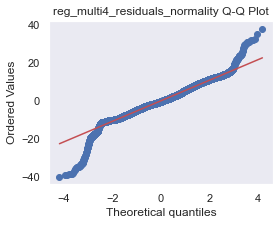

In [106]:
# 1. vérifier la normalité des résidus du model reg_multi4
plt.figure(figsize=(4,3))
stats.probplot(reg_multi4.resid, dist="norm", plot= plt)
plt.title("reg_multi4_residuals_normality Q-Q Plot")

#2. vérifier homosétasticité des résidus par statsmodels -  reg_multi4

name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test = sms.het_breuschpagan(reg_multi4.resid, reg_multi4.model.exog)
list(zip(name, test))


----
- P-value < 5%, rejet de H0 au niveau de test 5%, non-présence de hétéroscétasticité pour les résidus de ce modèle reg_multi4.
- Q-Q plot: normalité des résidus vérifiée 


In [107]:
# given the colinearity between energy-saturatedfat (coeff correlation 0.56), we can ignore one of them in multi reg
reg_multi3 = smf.ols('nutriscore~energy+ sugars + fiber', data=df2).fit()
reg_multi3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             nutriscore   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                 1.713e+04
Date:                Sat, 27 Aug 2022   Prob (F-statistic):               0.00
Time:                        12:24:27   Log-Likelihood:            -1.4463e+05
No. Observations:               44674   AIC:                         2.893e+05
Df Residuals:                   44670   BIC:                         2.893e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3251      0.052     -6.215      0.000      -0.428      -0.223
energy         0.0067   4.11e-05    163.743      0.000       0.007       0.007
sugars         0.1455      0.002     87.727      0.000       0.142       0.149
fiber         -0.6204      0.007    -84.990      0.000      -0.635      -0.606
==============================================================================
Omnibus:                     1057.075   Durbin-Watson:                   1.264
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1672.539
Skew:                           0.236   Prob(JB):                         0.00
Kurtosis:                       3.822   Cond. No.                     2.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Imputation of null values 

In [115]:
df2=df2.drop(['product_name','countries_fr'],axis=1)
print(df2.isna().mean())
print(df2.info())

category        0.352781
energy          0.000000
saturatedfat    0.000000
sugars          0.001943
fiber           0.000000
vitamins        0.000000
nutriscore      0.013449
nutrigrade      0.013449
dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 45283 entries, 36252 to 99111250
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   category      29308 non-null  object 
 1   energy        45283 non-null  float64
 2   saturatedfat  45283 non-null  float64
 3   sugars        45195 non-null  float64
 4   fiber         45283 non-null  float64
 5   vitamins      45283 non-null  float64
 6   nutriscore    44674 non-null  float64
 7   nutrigrade    44674 non-null  object 
dtypes: float64(6), object(2)
memory usage: 3.1+ MB
None


What we aim to do by imputation is to enable the further PCA etc. 

Columns to be imputed: sugars, nutriscore.

How ? based on the data groupby nutrigrade and category.  
Boz sugars and nutriscore vary with the nutrigrade - proved by ANOVA, histogram with "nutrigrade" as hue in jointplot, pairplot. 

In [116]:
df2.describe()

,energy,saturatedfat,sugars,fiber,vitamins,nutriscore
count,45283.000000,45283.000000,45195.000000,45283.000000,45283.000000,44674.000000
mean,1112.164404,4.918430,13.460442,2.505541,0.001928,7.588194
std,774.449452,8.212228,18.631867,4.131667,0.068610,9.036822
min,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,406.000000,0.300000,1.200000,0.000000,0.000000,0.000000
50%,1040.000000,1.600000,4.400000,1.330000,0.000000,7.000000
75%,1661.000000,6.200000,18.400000,3.200000,0.000000,14.000000
max,3770.000000,100.000000,104.000000,75.000000,7.596194,36.000000


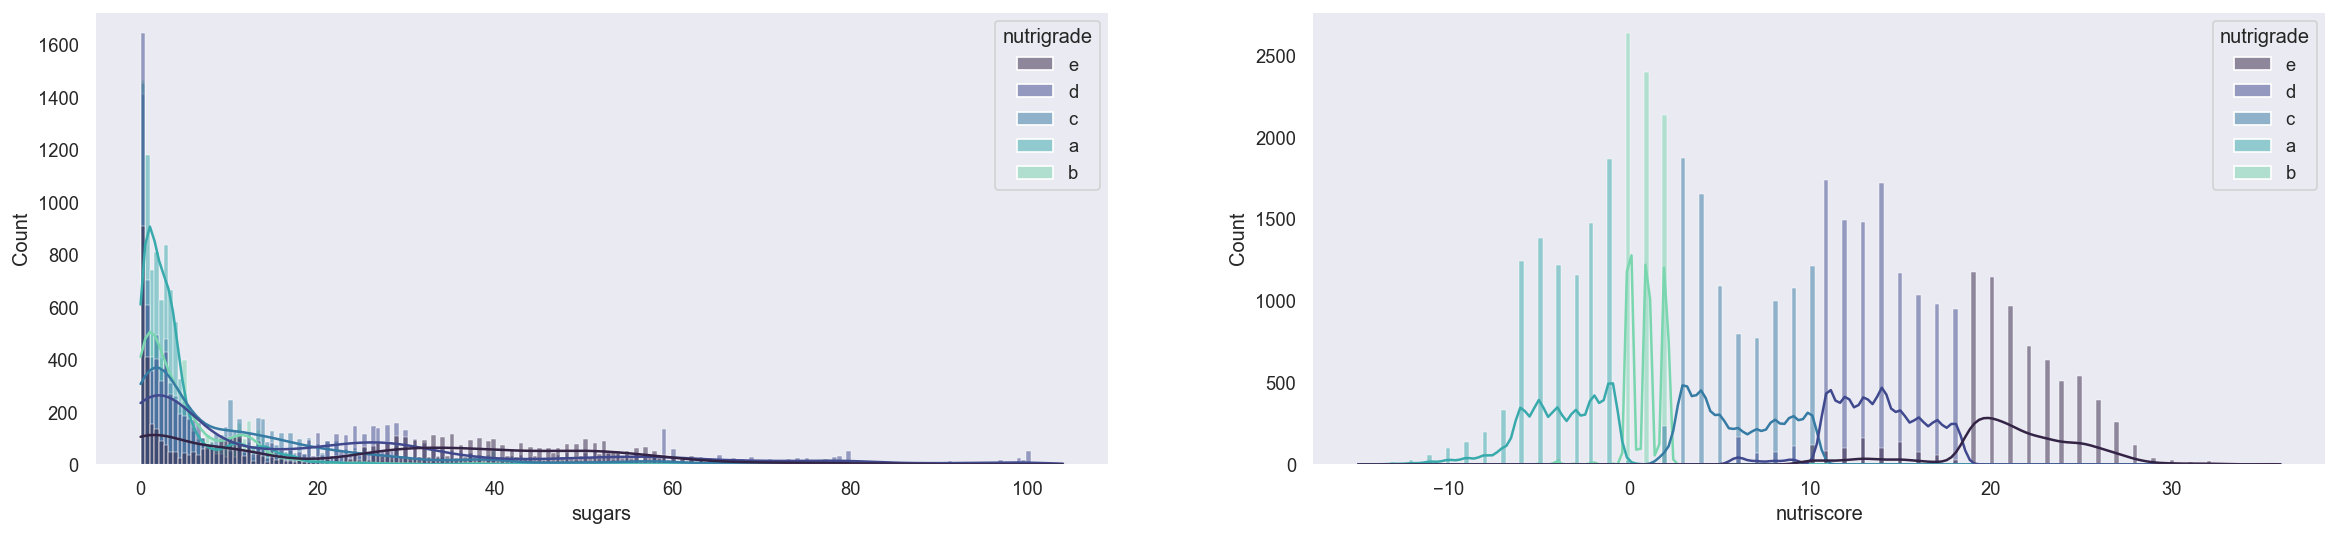

In [117]:
plt.figure(figsize= (24,5), dpi=120)
sns.set(style="dark")

plt.subplot(1,2,1)
ax= sns.histplot(data=df2, x="sugars", kde= True, palette='mako', hue="nutrigrade",bins=200)
plt.subplot(1,2,2)
ax= sns.histplot(data=df2, x="nutriscore", kde= True, palette='mako', hue="nutrigrade",bins=200)
plt.show()

In [150]:
df_imputed=df2.copy()
df_imputed.head(1)

,category,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,nutrigrade
code,,,,,,,,
36252,NaN,1883.0,12.5,57.5,2.5,0.0,22.0,e


In [121]:
#df_imputed.count()

In [152]:
# imputation 1
df_imputed.sugars = df_imputed.groupby(['category'],dropna=False)['sugars'].transform(lambda x: x.fillna(x.median()))    # many big values, it's better to choose median than mean boz mean is sensitive (non-robust) to outliers
df_imputed.nutriscore = df_imputed.groupby(['nutrigrade'],dropna=False)['nutriscore'].transform(lambda x: x.fillna(x.mean()))  # no remarkable difference between median n mean in nutriscore 
df_imputed.head()

,category,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,nutrigrade
code,,,,,,,,
36252,NaN,1883.0,12.5,57.5,2.5,0.0,22.0,e
10187319,NaN,1753.0,0.8,87.7,0.9,0.0,14.0,d
10207260,NaN,2406.0,2.9,50.3,3.9,0.0,14.0,d
40608754,"Boissons,Boissons gazeuses,Sodas,Sodas au cola...",177.0,0.0,10.4,0.0,0.0,13.0,e
69161025,NaN,1079.0,11.0,1.0,1.4,0.0,15.0,d


In [153]:
#df_imputed.describe()
df_imputed.count()

category        29308
energy          45283
saturatedfat    45283
sugars          45261
fiber           45283
vitamins        45283
nutriscore      44674
nutrigrade      44674
dtype: int64

This fillna() method does not work for nutriscore imputation given the fact that there're 44674 non-null nutrigrade and nutriscore. that means for 45283 - 44674 numbers of observations, they have neither nutriscore nor nutrigrade. So how to fillna in nutriscore given their corresponding nutrigrade is null ? try to groupby category for nutriscore imputation. 

In [154]:
# imputation 2
df_imputed.nutriscore = df_imputed.groupby(['category'],dropna=False)['nutriscore'].transform(lambda x: x.fillna(x.mean())) 
df_imputed.count()

category        29308
energy          45283
saturatedfat    45283
sugars          45261
fiber           45283
vitamins        45283
nutriscore      44899
nutrigrade      44674
dtype: int64

In [155]:
df_imputed.describe()

,energy,saturatedfat,sugars,fiber,vitamins,nutriscore
count,45283.000000,45283.000000,45261.000000,45283.000000,45283.000000,44899.000000
mean,1112.164404,4.918430,13.446936,2.505541,0.001928,7.584899
std,774.449452,8.212228,18.624421,4.131667,0.068610,9.031787
min,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,406.000000,0.300000,1.200000,0.000000,0.000000,0.000000
50%,1040.000000,1.600000,4.400000,1.330000,0.000000,7.000000
75%,1661.000000,6.200000,18.300000,3.200000,0.000000,14.000000
max,3770.000000,100.000000,104.000000,75.000000,7.596194,36.000000


there're still null in sugars and nutriscore. how ? Imputer

Groupby category or nutriscore, and then imputer with k-nearest neighbors algorithm (k-NN).

### 3rd imputation: KNN imputer 

In [157]:
df_imputed= df_imputed.reset_index().drop(['category','code'], axis=1).set_index('nutrigrade')
df_imputed.head(5)

,energy,saturatedfat,sugars,fiber,vitamins,nutriscore
nutrigrade,,,,,,
e,1883.0,12.5,57.5,2.5,0.0,22.0
d,1753.0,0.8,87.7,0.9,0.0,14.0
d,2406.0,2.9,50.3,3.9,0.0,14.0
e,177.0,0.0,10.4,0.0,0.0,13.0
d,1079.0,11.0,1.0,1.4,0.0,15.0


In [158]:
#from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

In [159]:
# impute missing values in each column with KNNImputer 

X=df_imputed.values
imputer = KNNImputer(n_neighbors=5).fit(X)
#imp_median = SimpleImputer(missing_values=np.nan, strategy='median').fit(X)
X_imp = imputer.transform(X)

#If “mean”, then replace missing values using the mean along each column. Can only be used with numeric data.
#If “median”, then replace missing values using the median along each column. Can only be used with numeric data.
#If “most_frequent”, then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.
#If “constant”, then replace missing values with fill_value. Can be used with strings or numeric data.

In [160]:
print(X_imp.shape)
X_imp[:3]

(45283, 6)


array([[1.883e+03, 1.250e+01, 5.750e+01, 2.500e+00, 0.000e+00, 2.200e+01],
       [1.753e+03, 8.000e-01, 8.770e+01, 9.000e-01, 0.000e+00, 1.400e+01],
       [2.406e+03, 2.900e+00, 5.030e+01, 3.900e+00, 0.000e+00, 1.400e+01]])

In [161]:
df_imputed=df_imputed.reset_index()
df_imputed.head(1)

,nutrigrade,energy,saturatedfat,sugars,fiber,vitamins,nutriscore
0,e,1883.0,12.5,57.5,2.5,0.0,22.0


In [162]:
df_imputed2 = pd.concat([df_imputed['nutrigrade'],
                                         pd.DataFrame(X_imp).rename({0:'energy',1: 'saturatedfat', 2: 'sugars', 3: 'fiber', 4: 'vitamins',5: 'nutriscore'},axis=1)], axis=1)
df_imputed2=df_imputed2.set_index('nutrigrade')
print(df_imputed2.info())
df_imputed2.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 45283 entries, e to c
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   energy        45283 non-null  float64
 1   saturatedfat  45283 non-null  float64
 2   sugars        45283 non-null  float64
 3   fiber         45283 non-null  float64
 4   vitamins      45283 non-null  float64
 5   nutriscore    45283 non-null  float64
dtypes: float64(6)
memory usage: 2.4+ MB
None


,energy,saturatedfat,sugars,fiber,vitamins,nutriscore
nutrigrade,,,,,,
e,1883.0,12.5,57.5,2.5,0.0,22.0
d,1753.0,0.8,87.7,0.9,0.0,14.0


In [ ]:
# imputation accomplie

### Exploratory Data Analysis: PCA 

In [135]:
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [163]:
# dimensionality reduction with PCA

df2_pca= df_imputed2.copy() #.drop(['light_score_100g'], axis=1)
print(df2_pca.info())
df2_pca.head(1)

<class 'pandas.core.frame.DataFrame'>
Index: 45283 entries, e to c
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   energy        45283 non-null  float64
 1   saturatedfat  45283 non-null  float64
 2   sugars        45283 non-null  float64
 3   fiber         45283 non-null  float64
 4   vitamins      45283 non-null  float64
 5   nutriscore    45283 non-null  float64
dtypes: float64(6)
memory usage: 2.4+ MB
None


,energy,saturatedfat,sugars,fiber,vitamins,nutriscore
nutrigrade,,,,,,
e,1883.0,12.5,57.5,2.5,0.0,22.0


In [164]:
# choix du nombre de composantes à calculer
n_comp = 4
X_pca = df_imputed2.values
names = df_imputed2.index           # nutrigrade as illustrative variable 
features = df_imputed2.columns         # = variables 
print(names)
print(features)

Index(['e', 'd', 'd', 'e', 'd', 'd', 'd', 'd', 'e', 'e',
       ...
       'd', 'd', 'd', 'b', 'c', 'd', 'b', 'a', 'b', 'c'],
      dtype='object', name='nutrigrade', length=45283)
Index(['energy', 'saturatedfat', 'sugars', 'fiber', 'vitamins', 'nutriscore'], dtype='object')


In [165]:
#X_pca = df2_pca.values
X_pca[:1]

array([[1883. ,   12.5,   57.5,    2.5,    0. ,   22. ]])

In [166]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X_pca)   #X_pca is values of df_imputed2
X_scaled = std_scale.transform(X_pca)
print(X_scaled[:2])
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp).fit(X_scaled)
X_projected = pca.transform(X_scaled)
print(X_projected[:2])

[[ 9.95344635e-01  9.23215175e-01  2.36577394e+00 -1.34103917e-03
  -2.81034207e-02  1.60130914e+00]
 [ 8.27481600e-01 -5.01505252e-01  3.98748867e+00 -3.88598183e-01
  -2.81034207e-02  7.14385602e-01]]
[[ 2.77754024 -0.30113605  0.18117457 -1.40295872]
 [ 2.05211604 -0.4882252   0.47925849 -3.46645345]]


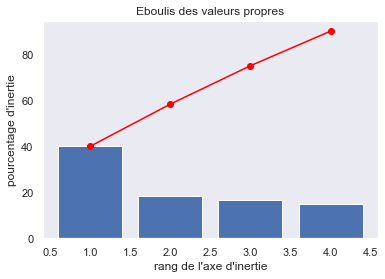

In [167]:
from functions66 import *
# Eboulis des valeurs propres
display_scree_plot(pca)

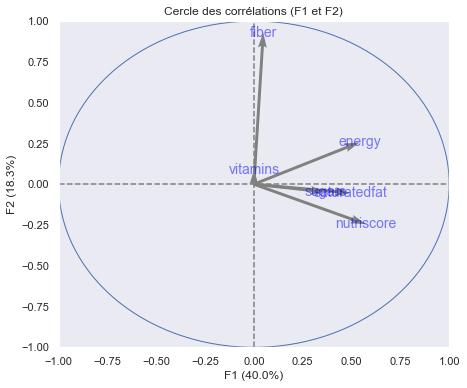

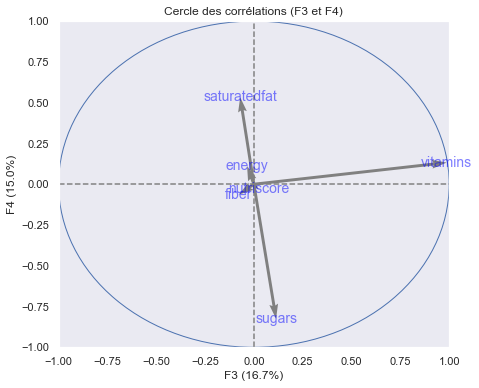

In [168]:
# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3)], labels = np.array(features))

According to screeplot and correlation circle: 
- we can reduce upmost to 4 dimensions (about 90%inertia) ; 
- and all the 5 explicative variables (indicators) are well reprensentated in these 4 factorial dimensions; 
- they're so well selected that we can hardly find a way to ignore any of them -- no big difference in inertia importance of these 4 dimensions as per screeplot.

## Scoring in order to get lightscore

#### Via Random Forest, we know the importance of each indicator for lightscore, then we can calculate (scoring) the lightscore for each observation. 

#### 2 approachs for scoring : scoring based on df_imputed2 or df_scaled  


##### Get the importances of different indicator-features for nutriscore. -  RandomForest

In [169]:
df2_RF = df_imputed2.set_index('nutriscore')
df2_RF.info()
df2_RF.head(1)

<class 'pandas.core.frame.DataFrame'>
Float64Index: 45283 entries, 22.0 to 2.0
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   energy        45283 non-null  float64
 1   saturatedfat  45283 non-null  float64
 2   sugars        45283 non-null  float64
 3   fiber         45283 non-null  float64
 4   vitamins      45283 non-null  float64
dtypes: float64(5)
memory usage: 2.1 MB


,energy,saturatedfat,sugars,fiber,vitamins
nutriscore,,,,,
22.0,1883.0,12.5,57.5,2.5,0.0


In [170]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X= df2_RF.values                     # imputed data 1-5 columns 
y= df2_RF.index.astype(str)     # imputed data 6th columns : nutriscore
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [171]:
#A Random Forest classifier will be fitted to compute the feature importances.

feature_names= df2_RF.columns             #df_pca: feature selection is between imputer and scaler
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [172]:
import time

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.671 seconds


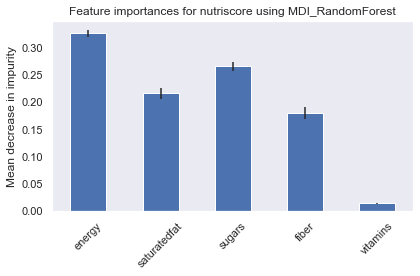

In [173]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances for nutriscore using MDI_RandomForest")
ax.set_ylabel("Mean decrease in impurity")

plt.xticks(rotation=45)
fig.tight_layout()

=> these 5 variables-features are of various importances for nutriscore.

We can take the case of nutriscore as a reference for the calculation of lightscore. 

In [174]:
df_imputed2['lightscore'] = round((- df_imputed2.energy*std[0] - df_imputed2['saturatedfat']*std[1] - df_imputed2['sugars']*std[2] 
                                        + df_imputed2.fiber*std[3]+df_imputed2['vitamins']*std[4]), 2)

df_imputed2.sort_values('lightscore', ascending= True).head()

,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,lightscore
nutrigrade,,,,,,,
e,3766.0,100.0,0.0,0.0,0.0,20.0,-25.07
e,3766.0,95.0,0.0,0.0,0.0,20.0,-25.02
d,3766.0,95.0,0.0,0.0,0.0,15.0,-25.02
e,3766.0,95.0,0.0,0.0,0.0,20.0,-25.02
e,3766.0,94.0,0.0,0.0,0.0,20.0,-25.01


In [176]:
df_imputed2.lightscore.describe()

count    45283.000000
mean        -7.251750
std          5.043697
min        -25.070000
25%        -10.890000
50%         -6.830000
75%         -2.670000
max          0.640000
Name: lightscore, dtype: float64

In [175]:
# df_scaled is the scaled df_imputed via StandardScaler in step PCA

df_scaled= pd.concat([df_imputed['nutrigrade'],
                   pd.DataFrame(X_scaled).rename({0:'energy',1: 'saturatedfat', 2: 'sugars', 3: 'fiber', 4: 'vitamins',5:'nutriscore'},axis=1)], axis=1)
df_scaled=df_scaled.set_index('nutrigrade')
df_scaled.head(1)


,energy,saturatedfat,sugars,fiber,vitamins,nutriscore
nutrigrade,,,,,,
e,0.995345,0.923215,2.365774,-0.001341,-0.028103,1.601309


In [177]:

# std is the importance of variable-features by RandomForest
df_scaled['lightscore'] = round((- df_scaled.energy*std[0] - df_scaled['saturatedfat']*std[1] - df_scaled['sugars']*std[2] 
                                        + df_scaled.fiber*std[3]+df_scaled['vitamins']*std[4]), 2)
df_scaled.sort_values('lightscore', ascending= True).head()

,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,lightscore
nutrigrade,,,,,,,
e,3.426776,11.578176,-0.721928,-0.60643,-0.028103,1.379578,-0.14
e,0.600221,10.116924,3.037013,-0.60643,-0.028103,2.709964,-0.14
e,0.465930,9.873382,2.392624,-0.60643,-0.028103,1.823040,-0.13
d,3.419029,10.482237,-0.721928,-0.60643,-0.028103,0.825251,-0.13
e,3.426776,10.725779,-0.721928,-0.60643,-0.028103,1.379578,-0.13


In [ ]:
#df2_scaled.head()

Text(0.5, 1.0, 'correlation heatmap_imputed n scaled')

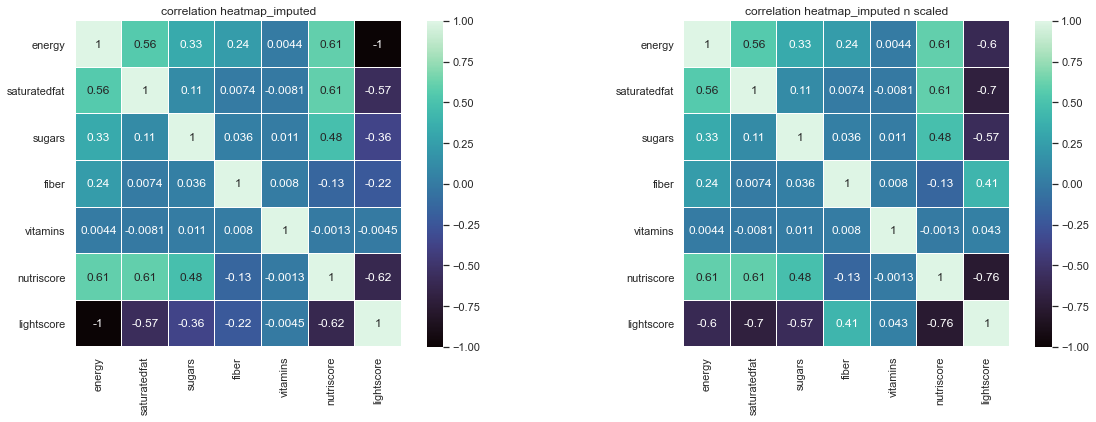

In [182]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
ax= sns.heatmap(df_imputed2.corr(),
            linewidths=.01,  
            annot=True, 
            square=True,
            cmap='mako',
            vmax=1,
            vmin=-1)
plt.title('correlation heatmap_imputed')

plt.subplot(1,2,2)
ax= sns.heatmap(df_scaled.corr(),
            linewidths=.01,  
            annot=True, 
            square=True,
            cmap='mako',
            vmax=1,
            vmin=-1)

plt.title('correlation heatmap_imputed n scaled')

<font color='blue'> 
    the result of light_score based on df_scaled is more reasonable than that of df_imputed2.
   for that normally lightscore should be negatively correlated with first 3 features, positively with the 2 middle, and negatively with nutriscore. </font>

In [ ]:
#df_scaled.corr()[:-1]

In [ ]:
#df_scaled['lightscore100'] = df_scaled['lightscore']*100

In [183]:
df_scaled.lightscore.describe()['min']
df_scaled.lightscore.describe()

count    45283.000000
mean         0.000023
std          0.020732
min         -0.140000
25%         -0.010000
50%          0.010000
75%          0.010000
max          0.200000
Name: lightscore, dtype: float64

In [184]:
print(df_scaled.lightscore.std(axis=0))
print(df_scaled.lightscore.min())
print(df_scaled.describe().lightscore['25%'])
print(df_scaled.describe().lightscore['50%'])
print(df_scaled.describe().lightscore['75%'])

# Median and 75% is same ! impossible to classify as per quantile 
# solution: instead of 50% median, take mean 

0.020732029316972773
-0.14
-0.01
0.01
0.01


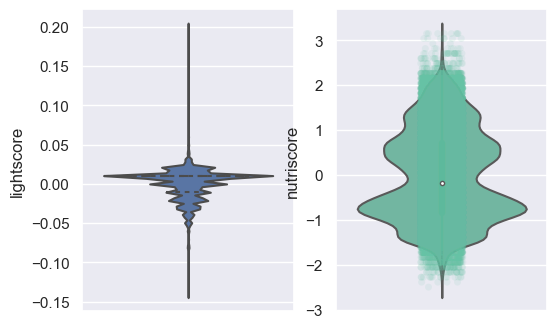

In [193]:
plt.figure(figsize= (6,4), dpi=100)
sns.set(style="darkgrid")

plt.subplot(1,2,1)
#ax=sns.stripplot(y="lightscore", data=df_scaled, cmap='viridis', alpha=0.3)
ax=sns.violinplot(y="lightscore", data=df_scaled, inner="quart",cmap='viridis')

plt.subplot(1,2,2)
ax=sns.stripplot(y="nutriscore",  data=df_scaled, palette="Set2", alpha=0.1)
ax=sns.violinplot(y="nutriscore",  data=df_scaled, palette='Set2')
plt.show()

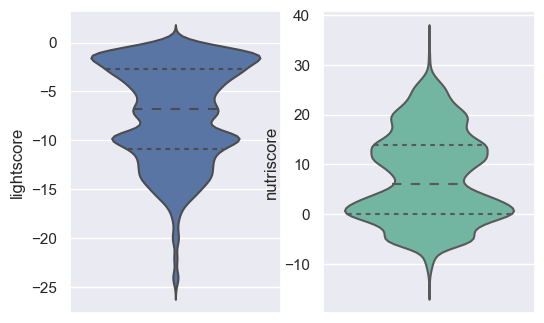

In [194]:
plt.figure(dpi=100)
sns.set(style="darkgrid")
plt.subplot(1,2,1)
#ax=sns.stripplot(y="lightscore", data=df_imputed2, cmap='viridis', alpha=0.3)
ax=sns.violinplot(y="lightscore", data=df_imputed2, inner="quart",cmap='viridis')

plt.subplot(1,2,2)
#ax=sns.stripplot(y="nutriscore",  data=df_scaled, palette="Set2", alpha=0.1)
ax=sns.violinplot(y="nutriscore",  data=df_imputed2, inner="quart", palette='Set2')
plt.show()

In [188]:
# linear reg of 2 scores
reg_2score= smf.ols('lightscore~nutriscore', data=df_scaled).fit()
reg_2score.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lightscore   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                 6.150e+04
Date:                Sat, 27 Aug 2022   Prob (F-statistic):               0.00
Time:                        12:36:41   Log-Likelihood:             1.3069e+05
No. Observations:               45283   AIC:                        -2.614e+05
Df Residuals:                   45281   BIC:                        -2.614e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.341e-05   6.34e-05      0.369      0.712      -0.000       0.000
nutriscore    -0.0157   6.34e-05   -247.993      0.000      -0.016      -0.016
==============================================================================
Omnibus:                    14258.600   Durbin-Watson:                   1.513
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           697612.433
Skew:                           0.756   Prob(JB):                         0.00
Kurtosis:                      22.169   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Application of algorithm 
### Classification of lightscores into different lightgrade
Given the distribution of lightscore, we can try to classify into 4 grades 

In [189]:
# create classification functions 
def class_score(x):
    if x <= -0.01:
        return 'D'
    
    elif x > -0.01 and x <= 0.000023:
        return 'C'
    
    elif x > 0.000023 and x <= 0.01:
        return 'B'
    
    elif x > 0.01 and x <= 0.2:
        return 'A'
    else: 
        return 'No result'
    
df_scaled['lightgrade']= df_scaled['lightscore'].apply(lambda x: class_score(x))

In [190]:
df_scaled2= df_scaled.reset_index().groupby('lightgrade')#.count()
df_scaled2.head(1)

,nutrigrade,energy,saturatedfat,sugars,fiber,vitamins,nutriscore,lightscore,lightgrade
0,e,0.995345,0.923215,2.365774,-0.001341,-0.028103,1.601309,-0.04,D
3,e,-1.207535,-0.598922,-0.163457,-0.606430,-0.028103,0.603520,0.01,B
4,d,-0.042824,0.740559,-0.668229,-0.267580,-0.028103,0.825251,-0.00,C
20,d,0.725473,-0.379734,-0.426583,1.813927,-0.028103,0.381789,0.02,A


In [220]:
#df_scaled.describe

<Figure size 1800x1200 with 0 Axes>

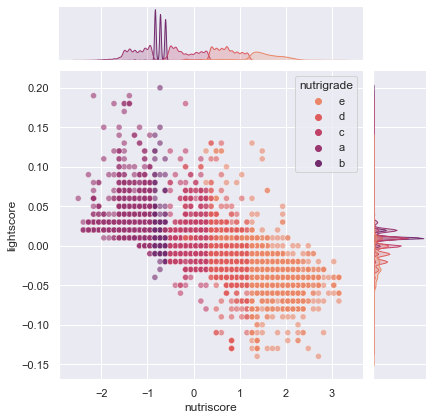

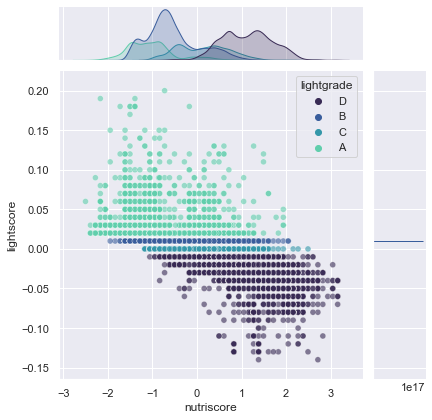

In [225]:
plt.figure(dpi=300)
sns.set(style="darkgrid")

ax=sns.jointplot(x= 'nutriscore', y= 'lightscore', data =df_scaled, hue="nutrigrade", palette='flare', alpha=0.6) 
ax1= sns.jointplot(x= 'nutriscore', y= 'lightscore', data= df_scaled, hue= "lightgrade", palette='mako', alpha=0.6)
plt.show()

In [191]:
#end